## Clustering de Clientes por Consumo de Energia - Modelagem

#### imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

#### Dataset

In [2]:
df = pd.read_csv('../data/household_power_consumption_nonavalues.txt')
df.drop(['Date','Time'], axis=1, inplace=True)
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2049275,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2049276,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2049277,0.938,0.000,239.82,3.8,0.0,0.0,0.0
2049278,0.934,0.000,239.70,3.8,0.0,0.0,0.0


#### Modelagem

In [3]:
df = df.values
pca = PCA(n_components=2).fit_transform(df)

O computador não consegue usar a função pdist em um vetor deste tamanho, por esse motivo foram feitas alguns treinamentos com 2% dos dados, afim de verificar se essa amostra é suficiente para explicar o conjunto de dados

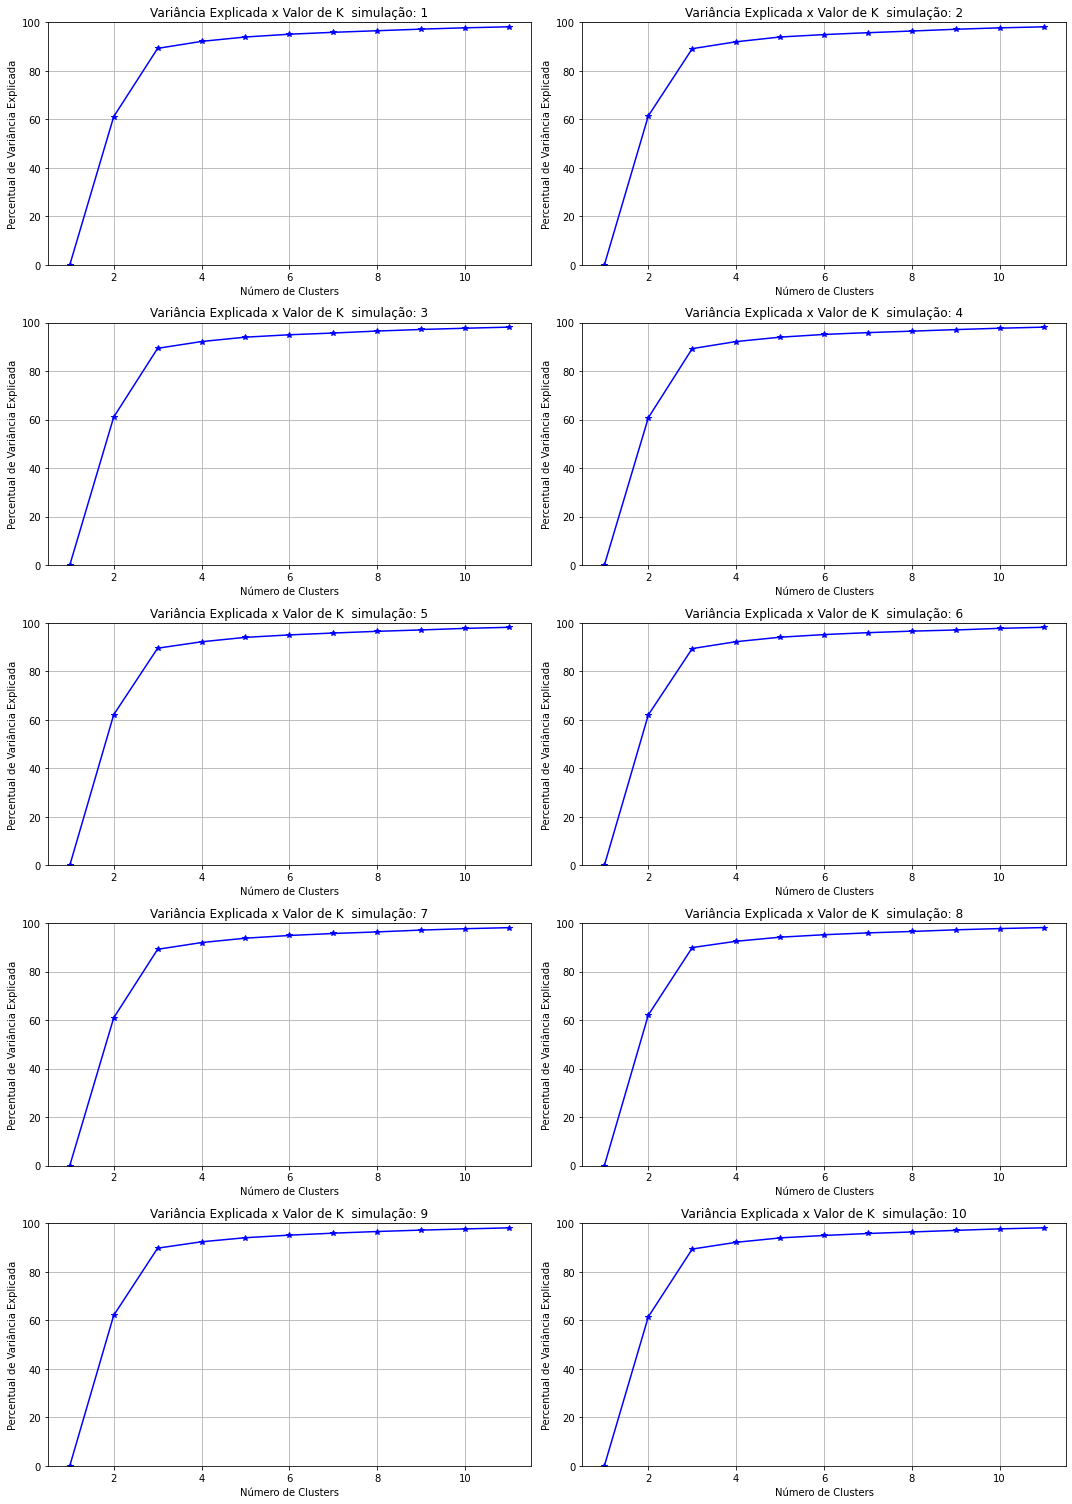

In [4]:
# Definindo o tamanho dos gráficos
fig = plt.figure()
fig.set_figheight(21)
fig.set_figwidth(15)

for i in range(10):
    
    amostra, complementar = train_test_split(pca, train_size = .02)
    del complementar
    
    # Determinando um range de K
    k_range = range(1,12)

    # Aplicando o modelo K-Means para cada valor de K (esta célula pode levar bastante tempo para ser executada)
    k_means_var = [KMeans(n_clusters = k).fit(amostra) for k in k_range]

    # Ajustando o centróide do cluster para cada modelo
    centroids = [X.cluster_centers_ for X in k_means_var]

    # Calculando a distância euclidiana de cada ponto de dado para o centróide
    k_euclid = [cdist(amostra, cent, 'euclidean') for cent in centroids]
    dist = [np.min(ke, axis = 1) for ke in k_euclid]

    # Soma dos quadrados das distâncias dentro do cluster
    soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

    # Soma total dos quadrados
    soma_total = sum(pdist(amostra)**2)/amostra.shape[0]

    # Soma dos quadrados entre clusters
    soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster
            
    # Plotando o resultado
    if (i+1) <= 10:
        plt.subplot(5,2,i+1)

        plt.plot(k_range, soma_quadrados_inter_cluster/soma_total * 100, 'b*-')
        ax = plt.gca()
        ax.set_ylim([0,100])
        plt.grid(True)
        plt.xlabel('Número de Clusters')
        plt.ylabel('Percentual de Variância Explicada')
        plt.title('Variância Explicada x Valor de K  simulação: '+str(i+1))
        
fig.tight_layout()
plt.show()

In [5]:
# Criando um modelo com K = 8, 9, 10, 11 e 12
modelos = dict()
amostra, complementar = train_test_split(pca, train_size = .02)
del pca, complementar

for i in range(8,13):
    m = KMeans(n_clusters = i)
    modelos.update({'modelo_k'+str(i) : m.fit(amostra)})

In [6]:
for key in modelos.keys():
    labels = modelos[key].labels_
    print(key,": ",silhouette_score(amostra, labels, metric = 'euclidean'))

modelo_k8 :  0.7959690649317142
modelo_k9 :  0.8067354433219308
modelo_k10 :  0.6667239206204683
modelo_k11 :  0.6209342040903874
modelo_k12 :  0.49435621525049533


O melhor número para K é 8

In [11]:
# Lista com nomes das colunas
names = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
         'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

amostra, complementar = train_test_split(df, train_size = .02)
                                         
cluster_map = pd.DataFrame(amostra, columns = names)
cluster_map['Global_active_power'] = pd.to_numeric(cluster_map['Global_active_power'])
cluster_map['Grupo'] = modelos['modelo_k8'].labels_

In [12]:
cluster_map

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Grupo
0,0.210,0.100,237.37,1.0,0.0,0.0,0.0,6
1,0.130,0.000,242.13,0.6,0.0,0.0,1.0,0
2,0.714,0.322,243.29,3.2,0.0,1.0,1.0,7
3,0.312,0.000,244.32,1.4,0.0,0.0,1.0,1
4,0.602,0.000,239.68,2.4,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...
40980,0.576,0.212,238.77,2.6,0.0,4.0,0.0,0
40981,1.394,0.116,238.50,5.8,0.0,0.0,17.0,0
40982,0.774,0.192,236.73,3.2,0.0,0.0,0.0,7
40983,0.452,0.102,237.08,2.0,0.0,0.0,0.0,3


A Partir do agrupamento podemos fazer análises para identificaqr diferenças e padrões entra os grupos

In [13]:
x = cluster_map.groupby('Grupo')['Global_active_power'].mean()

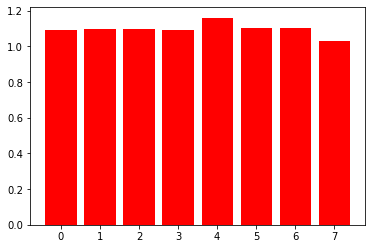

In [23]:
columns = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity',
           'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

fig = plt.figure()
fig.set_figheight(21)
fig.set_figwidth(15)


for i, col in enumerate(columns):
    
    plt.subplot(7,1,i+1)
    x = cluster_map.groupby('Grupo')[col].mean()
    
    plt.xlabel('Grupo')
    plt.ylabel(f'Valor médio {col}')
    plt.title(f'Valor médio )
    
    plt.bar(x.index, x, color='blue')

In [24]:

columns = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity',
           'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for i, col in enumerate(columns):
    print(i,col)

0 Global_active_power
1 Global_reactive_power
2 Voltage
3 Global_intensity
4 Sub_metering_1
5 Sub_metering_2
6 Sub_metering_3
